# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')
xq = np.load('pred/feats_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [4]:
xb.shape # nb-by-d

(57520, 512)

In [5]:
xq.shape # nq-by-d (query vectors)

(15476, 512)

In [6]:
yb.shape, yq.shape

((57520,), (15476,))

In [7]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 959)

In [8]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [9]:
xb.max()

25.498583

In [10]:
faiss.normalize_L2(xb)

In [11]:
xb.max()

0.20987545

In [12]:
index.train(xb)

In [13]:
index.add_with_ids(xb, yb)

In [14]:
print(index.is_trained)
print(index.ntotal)

True
57520


## Train dataset

In [15]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[ 127  444  649  444  444]
 [1043 1043 1043 1043 1043]
 [ 892  892  892  892  892]
 [ 666  666  666  666  666]
 [ 380  380  380  380  380]]
[[ 127]
 [1043]
 [ 892]
 [ 666]
 [ 380]]
[[1.         0.6633375  0.66299796 0.65372616 0.6391761 ]
 [1.         0.8616765  0.8598778  0.7860178  0.75030154]
 [0.99999976 0.9297686  0.9126613  0.90783507 0.9040182 ]
 [1.0000001  0.88243103 0.86449313 0.8441516  0.8400029 ]
 [1.         0.93055725 0.90805626 0.90743786 0.90628004]]


In [16]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [17]:
I_train[:,0].shape, yb.shape

((57520,), (57520,))

In [18]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [19]:
I_train[:10,0], yb[:10]

(array([ 127, 1043,  892,  666,  380,  992, 1032,  453,  445,  937]),
 array([ 127, 1043,  892,  666,  380,  992, 1032,  453,  445,  937]))

In [20]:
I_train[-10:,0], yb[-10:]

(array([ 947,  503,  469,  843,  773,   24,  509,  521, 1045,  197]),
 array([ 947,  503,  469,  843,  773,   24,  509,  521, 1045,  197]))

### Train confusion matrix

In [21]:
cm = confusion_matrix(I_train[:,0], yb)

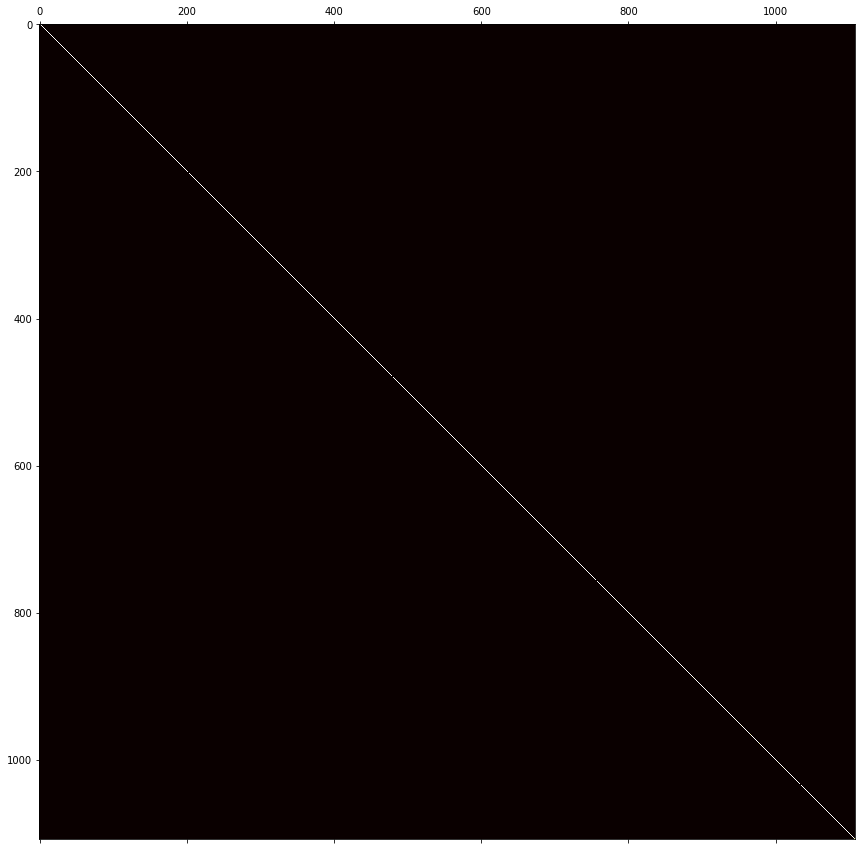

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

## Valid dataset

In [21]:
xq.max()

24.70578

In [22]:
faiss.normalize_L2(xq)

In [23]:
xq.max()

0.19800125

In [24]:
D_valid, I_valid = index.search(xq, k) # actual search

In [25]:
xq.shape, yq.shape

((15476, 512), (15476,))

In [26]:
I_valid.shape, D_valid.shape

((15476, 5), (15476, 5))

In [27]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[ 503    6 1076  133 1076]
 [ 798  798  838  883  798]
 [ 552  552  653  552  745]
 [  89  102   89  460  450]
 [ 775  296  555  109  411]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.7483196  0.7318468  0.7238261  0.71969354 0.68228954]
 [0.65773135 0.63916516 0.6083019  0.60802376 0.6004855 ]
 [0.7670809  0.7582499  0.68127555 0.6414081  0.63677174]
 [0.65077734 0.6361323  0.63464093 0.6153457  0.5907988 ]
 [0.7772075  0.7684262  0.7229198  0.71339524 0.70043635]]


In [28]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[1061  885  756  213  756]
 [ 292  107   71  574   58]
 [ 824  200  824  824  824]
 [ 568  304  528  528  323]
 [ 251   18  251  406  406]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.777071   0.74602485 0.7368281  0.6712646  0.6693068 ]
 [0.73252916 0.72164977 0.69479346 0.6826047  0.66423273]
 [0.81200695 0.77030534 0.6774694  0.6388584  0.62141997]
 [0.8003293  0.78722864 0.78391457 0.78303    0.77953345]
 [0.74303865 0.73843855 0.7230339  0.6754898  0.6516497 ]]


In [29]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [30]:
I_valid[:,0]

array([503, 798, 552, ..., 824, 568, 251])

In [31]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [32]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

6102

In [33]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.3942879296975963

In [34]:
valid_correct = np.equal(I_valid[:,0], yq)

In [35]:
valid_correct

array([False, False, False, ...,  True, False, False])

In [36]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [37]:
cm = confusion_matrix(I_valid[:,0], yq)

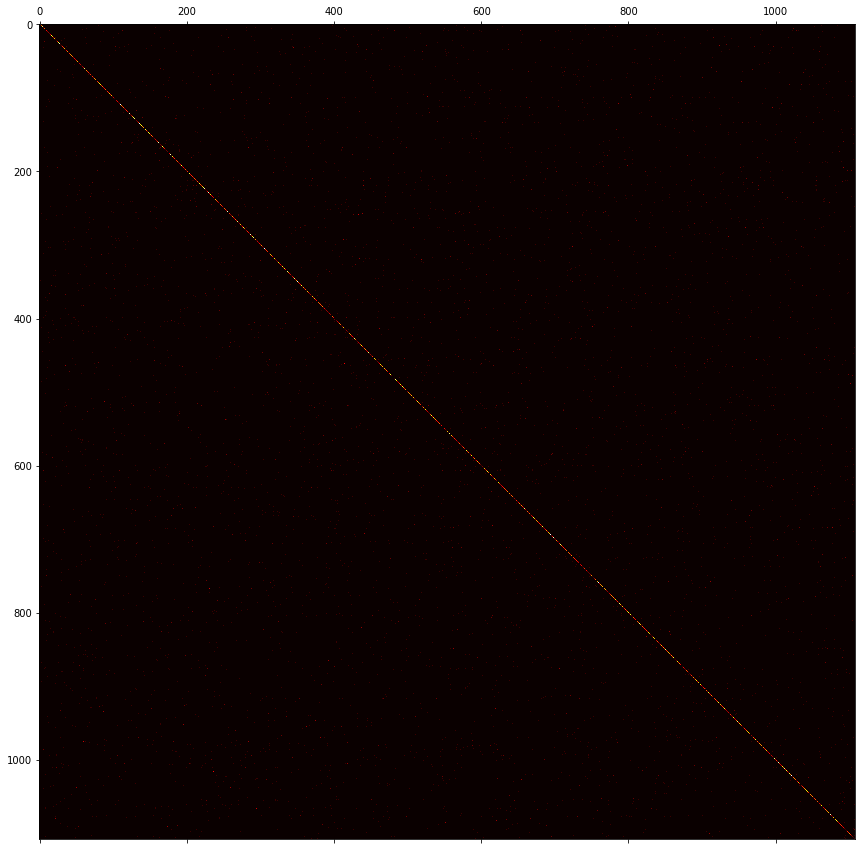

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

1506

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

6232

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.19462393383303178

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [39]:
xq_test = np.load('pred/feats_test.npy')

In [40]:
xq_test.max()

23.913994

In [41]:
faiss.normalize_L2(xq_test)

In [42]:
xq_test.max()

0.20042199

In [43]:
D_test, I_test = index.search(xq_test, k) # actual search

In [44]:
xq_test.shape, I_test.shape, D_test.shape

((39794, 512), (39794, 5), (39794, 5))

In [45]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[ 904  904  904  904  904]
 [  31  261  143   31  261]
 [ 199  199  199  199  199]
 [1075 1075  249 1075  249]
 [ 756   54  728  519  594]]
[[0.62888443 0.61039853 0.6093577  0.6022858  0.59902906]
 [0.6849106  0.6742103  0.62600136 0.5828593  0.5757047 ]
 [0.8128415  0.7511911  0.7231127  0.71877587 0.7163707 ]
 [0.7081035  0.6901996  0.6696239  0.6534012  0.64511216]
 [0.74631596 0.7250635  0.7249367  0.7244868  0.71202445]]


In [46]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[1074 1074 1074 1074 1074]
 [ 183  338 1071  338  338]
 [  98   98   98   98   98]
 [  98   98   34   34   34]
 [ 283  283  283  283  283]]
[[0.6393613  0.59812784 0.59732145 0.58595294 0.57206   ]
 [0.61366826 0.5979966  0.5905865  0.58855784 0.5768117 ]
 [0.7797704  0.7600624  0.73277223 0.71968055 0.71238077]
 [0.65812707 0.6451863  0.64505196 0.6389815  0.6215651 ]
 [0.7149108  0.6975584  0.68391675 0.6676514  0.6573858 ]]


In [47]:
I_test[2]

array([199, 199, 199, 199, 199])

In [48]:
np.unique(I_test[2], return_counts=True)

(array([199]), array([5]))

In [49]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [50]:
np.save('pred/preds_test.npy', preds_test)
np.save('pred/dist_test.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)